# Integrated Simulations

In [1]:
import os
from os import listdir
from os.path import isfile, join
import re
#from skimage import io
from skimage.io import imread
# To manipulate arrays
import numpy as np
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
from skimage.measure import find_contours
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
# To create interactive elements
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord
# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()


In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases', 'gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases', 'videos_for_sim_cell')
#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
trajectories_dir = current_dir.parents[1].joinpath(
    'DataBases', 'rsnapsim_simulations', 'kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath(
    'DataBases', 'gene_files', 'KDM5B_withTags.txt')


In [3]:
# Paths to dropbox
from sys import platform as _platform
if _platform == "linux" or _platform == "linux2":
    dropbox_address = pathlib.Path(
        '/', 'home', 'luisub', 'Dropbox', 'Project_rSNAPed', 'manuscript', 'Figures')
elif _platform == "darwin":
    dropbox_address = pathlib.Path(
        '/', 'Users', 'luisaguilera', 'Dropbox', 'Project_rSNAPed', 'manuscript', 'Figures')


In [4]:
# Importing rSNAPed
import rsnaped as rsp
sys.path.append(str(rsnaped_dir))


In [61]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False


In [6]:
from dna_features_viewer import BiopythonTranslator


class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """

    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#ff0000"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7":
            return "#EB5559"
        else:
            return "#C4B07B"


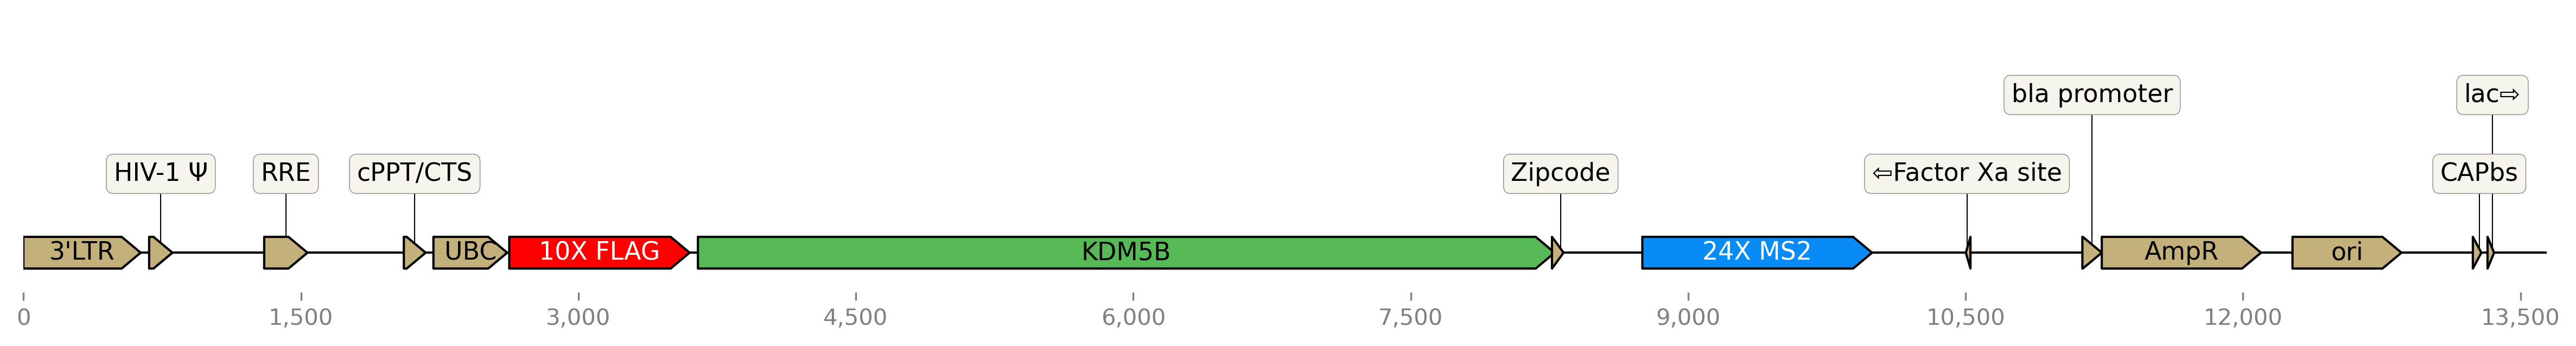

In [7]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath(
    'kdm5b.gb'))  # plasmid pUB_SM_KDM5B_PP7
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7)
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
#ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
name_figure = 'sequence.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
ax.figure.savefig(figure_directory)


In [8]:
plt.style.use('ggplot')


In [9]:
# These are the parameters that need to be tested.
number_of_simulated_cells = 20  # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 50     # PLEASE TEST MIN 5 MAX 200
diffusion_coefficient = 0.7    # PLEASE TEST MIN 0.1 MAX 2


In [10]:
# options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
intensity_calculation_method = 'disk_donut'
mask_selection_method = 'max_area'  # options are : 'max_spots' and 'max_area'
use_optimization_for_tracking = 1  # 0 not using, 1 is using optimization
# Options are: 'constant' , 'shuffle' and 'loop'
frame_selection_empty_video = 'shuffle'


In [11]:
particle_size = 7  # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03


In [12]:
# Perturbations
use_Harringtonin = 0
use_FRAP = 0

name_files = 'Pipeline_'
simulation_time_in_sec = 801
perturbation_time_start = 0
perturbation_time_stop = 0


In [13]:
intensity_scale_ch0 = 200
intensity_scale_ch1 = 400
intensity_scale_ch2 = 400


In [14]:
particle_detection_size = particle_size


## Running the simulations

In [15]:
def fun_simulated_cells(current_dir, video_dir, ke=3, ki=0.03, gene_file=None, trajectories_dir=None, number_of_simulated_cells=3, number_spots_per_cell=80,
                        simulation_time_in_sec=100, step_size_in_sec=1, particle_size=5, diffusion_coefficient=1, path_to_rSNAPsim=None, path_to_save_output='temp',
                        intensity_calculation_method='gaussian_fit', frame_selection_empty_video=frame_selection_empty_video,
                        perturbation_time_start=perturbation_time_start, perturbation_time_stop=perturbation_time_stop, use_Harringtonin=use_Harringtonin, use_FRAP=use_FRAP):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.', '_')
    directory_name = 'Simulation_V2__'+'ns_' + \
        str(number_spots_per_cell) + '_diff_' + diffusion_coefficient_string
    path_to_save_output = 'temp'
    save_to_path = current_dir.joinpath(path_to_save_output, directory_name)
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    # Main loop that creates each cell and dataframe
    for cell_number in range(0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(
            output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        # sorting the index in numerical order
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))
        # creating the complete path for each file
        path_files = [str(video_dir.joinpath(f).resolve())
                      for f in list_files_names]
        selected_video = 2
        video_path = path_files[selected_video]
        video = imread(video_path)
        # Reducing in a half the intensity in the original video
        video = video//2
        empty_videos = video
        counter += 1
        if counter >= len(path_files):
            counter = 0
        if not (trajectories_dir is None):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch0 = np.random.randint(
                low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch1 = np.random.randint(
                low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(
                low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))

            simulated_trajectories_ch0 = ssa_trajectories[random_index_ch0,
                                                          0:simulation_time_in_sec:step_size_in_sec] / 10  # converting to ump
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,
                                                          0:simulation_time_in_sec:step_size_in_sec] / 10  # converting to ump
            simulated_trajectories_ch2 = ssa_trajectories[random_index_ch2,
                                                          0:simulation_time_in_sec:step_size_in_sec] / 10  # converting to ump
        else:
            # Simulations for intensity
            # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time
            ssa1, ssa1_ump, _ = rsp.SSA_rsnapsim(gene_file, ke, ki, frames=simulation_time_in_sec, frame_rate=1, n_traj=number_spots_per_cell, use_Harringtonin=use_Harringtonin,
                                                 use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start, perturbation_time_stop=perturbation_time_stop).simulate()
            simulated_trajectories_ch1 = ssa1_ump
            # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time
            ssa2, ssa2_ump, _ = rsp.SSA_rsnapsim(gene_file, ke, ki, frames=simulation_time_in_sec, frame_rate=1, n_traj=number_spots_per_cell, use_Harringtonin=use_Harringtonin,
                                                 use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start, perturbation_time_stop=perturbation_time_stop).simulate()
            simulated_trajectories_ch2 = ssa2_ump
            simulated_trajectories_ch0 = simulated_trajectories_ch1
        #simulated_trajectories_ch0 = None
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath(
            'sim_cell_'+str(cell_number)))
        tensor_video, spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell(base_video=video, number_spots=number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient=diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2,
                                                                                                   size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0, ignore_ch1=0, ignore_ch2=1, save_as_tif_uint8=0, save_as_tif=1, save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name, create_temp_folder=False, intensity_calculation_method=intensity_calculation_method, perform_video_augmentation=0, frame_selection_empty_video=frame_selection_empty_video, intensity_scale_ch0=intensity_scale_ch0, intensity_scale_ch1=intensity_scale_ch1, intensity_scale_ch2=intensity_scale_ch2).make_simulation()
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos


In [16]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir, video_dir, ke=elongation_rate, ki=initiation_rate, trajectories_dir=None, gene_file=gene_file, number_of_simulated_cells=number_of_simulated_cells, number_spots_per_cell=number_spots_per_cell, simulation_time_in_sec=simulation_time_in_sec,
                                                                                                                                              step_size_in_sec=1, particle_size=particle_size, diffusion_coefficient=diffusion_coefficient, path_to_rSNAPsim=None, intensity_calculation_method=intensity_calculation_method, frame_selection_empty_video=frame_selection_empty_video, perturbation_time_start=perturbation_time_start, perturbation_time_stop=perturbation_time_stop, use_Harringtonin=use_Harringtonin, use_FRAP=use_FRAP)
end = timer()
print('Time to generate simulated data:', round(end - start), ' sec')


Time to generate simulated data: 427  sec


In [17]:
output_directory_name


PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Paper_Figures/temp/Simulation_V2__ns_50_diff_0_7')

In [18]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(
    output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
# sorting the index in numerical order
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))
path_files = [str(output_directory_name.joinpath(f).resolve())
              for f in list_files_names]  # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:, :, :, :]
                        for f in path_files]  # List with all the videos
nimg = number_of_simulated_cells


In [19]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range(0, nimg):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0, number_channels):
            temp_img[:, :, :, j] = np.asarray([rescale_intensity(
                list_videos_original[i][z, :, :, j], in_range='image', out_range='dtype') for z in range(0, number_z_slices)])
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original


## Display results as images

In [20]:
def df_to_array(dataframe_simulated_cell):
    '''
    This function takes the dataframe and extracts the information from it. 
    Information is separated by particles. Notice that dataframe contains information about 600 particles.

    Input
        dataframe_simulated_cell : pandas dataframe

    Returns
        I_g : Intensities for each particle in the green channel. NumPy array with dimensions [number_particles, time_points]
        I_g_std : Std for the intensities for each particle in the green channel.  NumPy array with dimensions [number_particles, time_points]
        I_r : Intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        I_r_std : Std for the intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        x_loc : x position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]
        y_loc : y position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]

    '''
    # get the total number of particles in all cells
    total_particles = 0
    for cell in set(dataframe_simulated_cell['cell_number']):
        total_particles += len(set(
            dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle']))

    # preallocate numpy array sof n_particles by nframes
    # intensity green
    I_g = np.zeros([total_particles, np.max(
        dataframe_simulated_cell['frame'])+1])
    I_g_std = np.zeros([total_particles, np.max(
        dataframe_simulated_cell['frame'])+1])  # intensity green std
    x_loc = np.zeros([total_particles, np.max(
        dataframe_simulated_cell['frame'])+1])  # x loc
    y_loc = np.zeros([total_particles, np.max(
        dataframe_simulated_cell['frame'])+1])  # y_loc
    I_r_std = np.zeros([total_particles, (np.max(
        dataframe_simulated_cell['frame'])+1)])  # intensity red
    # intensity red std
    I_r = np.zeros(
        [total_particles, (np.max(dataframe_simulated_cell['frame'])+1)])
    k = 0

    # For loops that iterate for each particle and stores the data in the previously pre-alocated arrays.
    for cell in set(dataframe_simulated_cell['cell_number']):  # for every cell
        # for every particle
        for particle in set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle']):
            tmpdf = dataframe_simulated_cell[(dataframe_simulated_cell['cell_number'] == cell) & (
                dataframe_simulated_cell['particle'] == particle)]  # slice the dataframe
            maxframe = np.max(tmpdf['frame'])
            minframe = np.min(tmpdf['frame'])
            # fill the arrays to return out
            I_g[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_mean']
            x_loc[k, 0:(maxframe+1-minframe)] = tmpdf['x']
            y_loc[k, 0:(maxframe+1-minframe)] = tmpdf['y']
            I_g_std[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_std']
            I_r[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_mean']
            I_r_std[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_std']
            k += 1  # iterate over k (total particles)
    return I_g, I_g_std, I_r, I_r_std, x_loc, y_loc  # return everything backout


In [21]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(
    output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
# sorting the index in numerical order
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))
path_files = [str(output_directory_name.joinpath(f).resolve())
              for f in list_files_names]  # creating the complete path for each file
# Reading the microscopy data
list_videos_original = [imread(f)[:, :, :, :]
                        for f in path_files]  # List with all the videos
nimg = number_of_simulated_cells


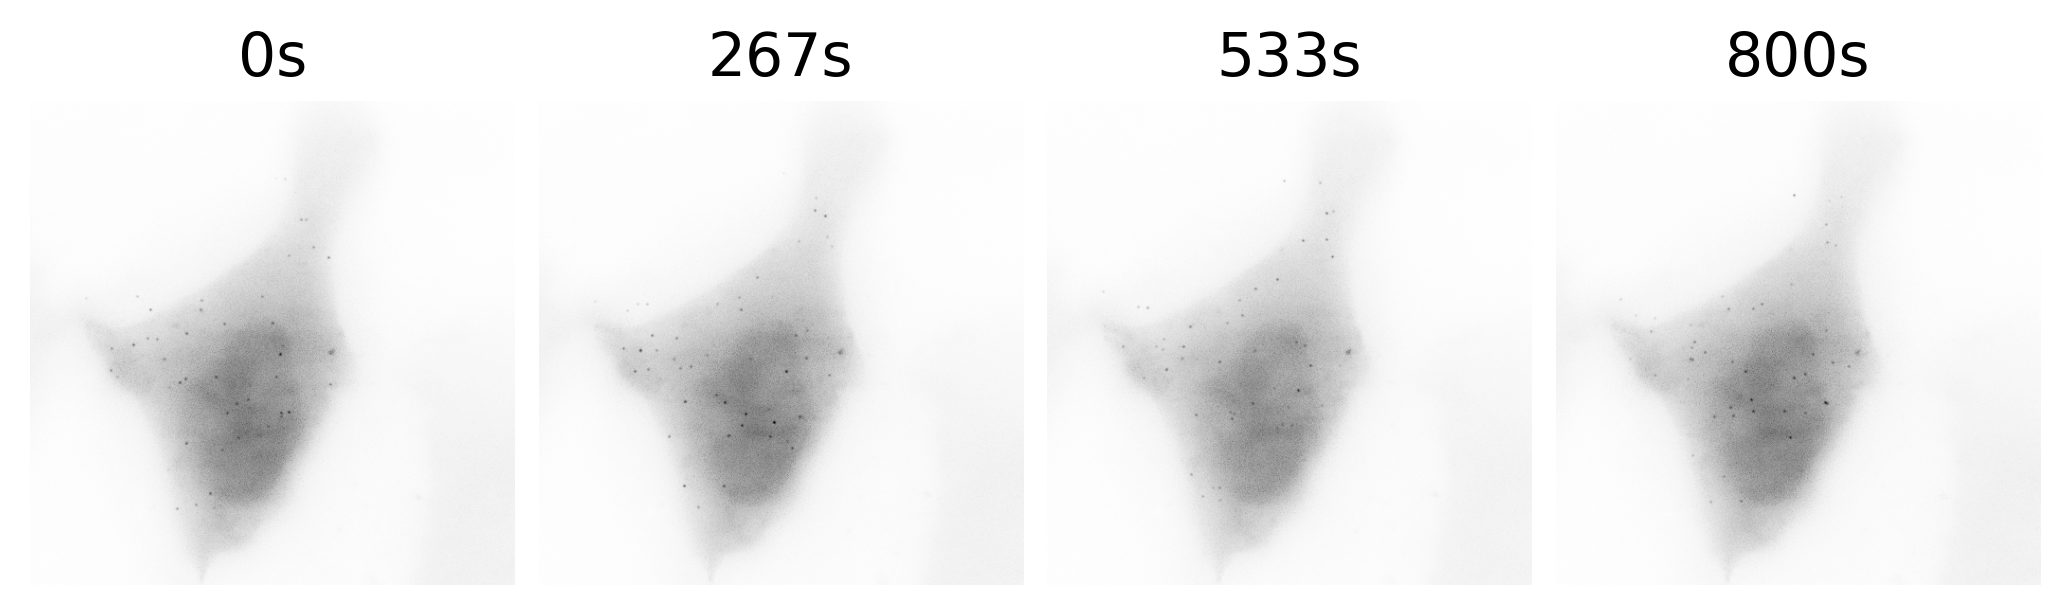

In [22]:
ncrops = 4
time_vector = np.round(np.linspace(
    0, simulation_time_in_sec-1, ncrops)).astype(int)

#time_vector = [0, 100, 200, 300]
ncrops = len(time_vector)
time_vector
channel = 1
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
max_val = []
min_val = []
for i in range(0, ncrops):
    temp_img = list_videos[0][time_vector[i], :, :, channel]
    max_val.append(np.amax(temp_img))
    min_val.append(np.amin(temp_img))  # running the simulation

for i in range(0, ncrops):
    axes[i].imshow(list_videos[0][time_vector[i], :, :, channel],
                   cmap='Greys', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
    axes[i].set(title=str(time_vector[i]) + 's')
name_figure = name_files+'_cells.png'
figure_directory = str(dropbox_address.joinpath(name_figure))

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


In [23]:
# Extracting the number of real simulations from folder name
list_df = []
for i in range(0, number_of_simulated_cells):
    file_name = str(output_directory_name.joinpath(
        'sim_cell_'+str(0)+'_df.csv'))
    temp_df = pd.read_csv(file_name)
    temp_df['cell_number'] = i
    list_df.append(temp_df)


df_intensities_real = pd.concat(list_df, ignore_index=True)

#df_intensities_real = pd.read_csv(file_name)
I_g, I_g_std, I_r, I_r_std, x_loc, y_loc = df_to_array(df_intensities_real)


In [38]:
selected_channel = 1
selected_masks = rsp.Cellpose(list_videos[0][0, :, :, selected_channel], num_iterations=10,
                              selection_method='max_cells', diameter=220).calculate_masks()  # options are 'max_area' or 'max_cells'
selected_mask = rsp.CellposeSelection(
    selected_masks, list_videos[0], selection_method=mask_selection_method, particle_size=particle_size, selected_channel=selected_channel).select_mask()


In [124]:
fig_size = (2, 2)
channel = 1
selected_timePoint = 0


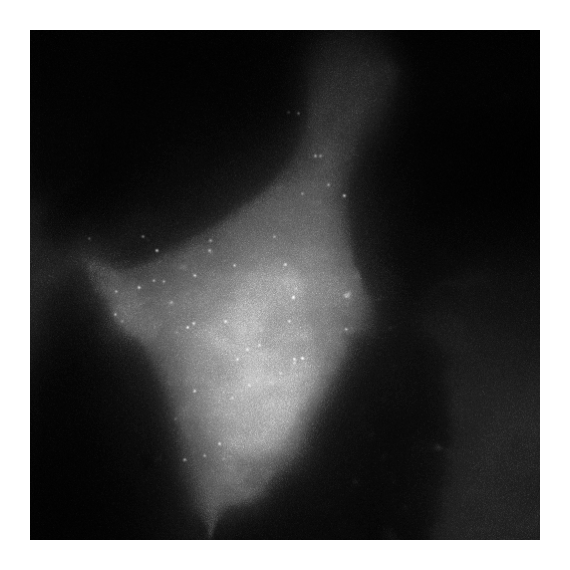

In [125]:
plt.figure(figsize=fig_size, dpi=300)
plt.imshow(list_videos[0][selected_timePoint, :, :, channel], cmap='Greys_r')
temp_border = list_videos[0][selected_timePoint, :, :, channel].copy()
plt.axis('off')
name_figure = name_files+'_CELL_simulated.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.tight_layout()
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


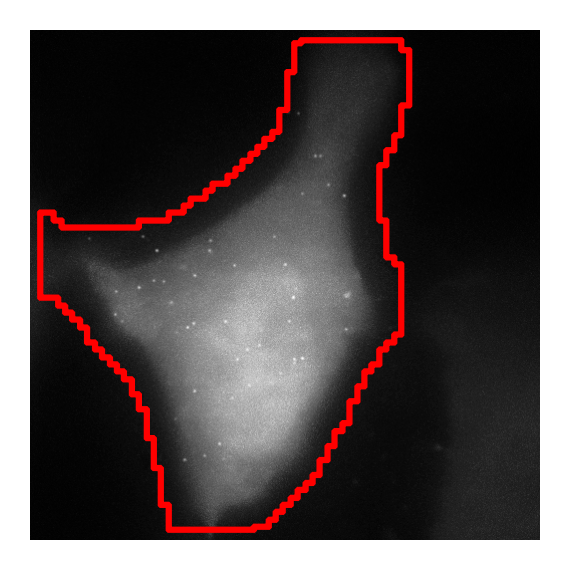

In [126]:
plt.figure(figsize=fig_size, dpi=300)
plt.imshow(list_videos[0][selected_timePoint, :, :, channel], cmap='Greys_r')
contuour_position = find_contours(selected_mask[:, :], 0.8)
plt.fill(contuour_position[0][:, 1], contuour_position[0][:, 0],
         facecolor='none', edgecolor='red', linewidth=1.5)  # mask nucleus
plt.axis('off')
name_figure = name_files+'_CELL_mask.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.tight_layout()
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


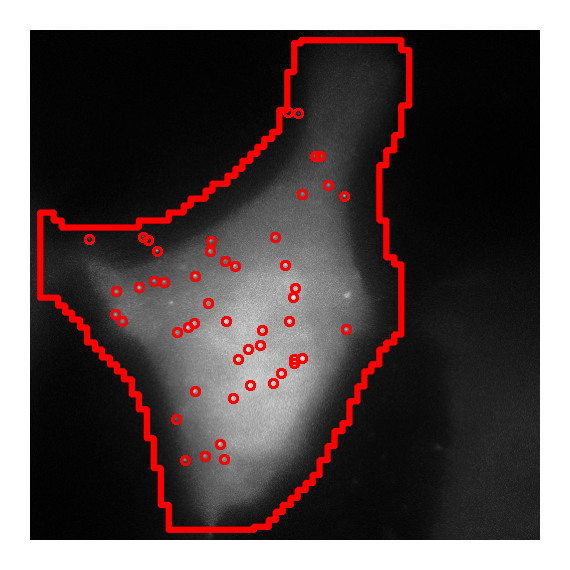

In [127]:
plt.figure(figsize=fig_size, dpi=300)
plt.imshow(list_videos[0][selected_timePoint, :, :, channel], cmap='Greys_r')
contuour_position = find_contours(selected_mask[:, :], 0.8)
plt.fill(contuour_position[0][:, 1], contuour_position[0][:, 0],
         facecolor='none', edgecolor='red', linewidth=1.5)  # mask nucleus
# this loop iterated for each trajectory. This is achieved by using the total number of rows in x_loc, using this: ==> "x_loc.shape[0]"
for i in range(0, x_loc.shape[0]):
    # Then we plot the complete trajectory for each particle.
    plt.plot(x_loc[i, 0], y_loc[i, 0], marker='o', markersize=2,
             markerfacecolor='none', markeredgewidth=0.5, markeredgecolor='r')
    plt.axis('off')
name_figure = name_files+'_CELL_spot_detected.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.tight_layout()
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


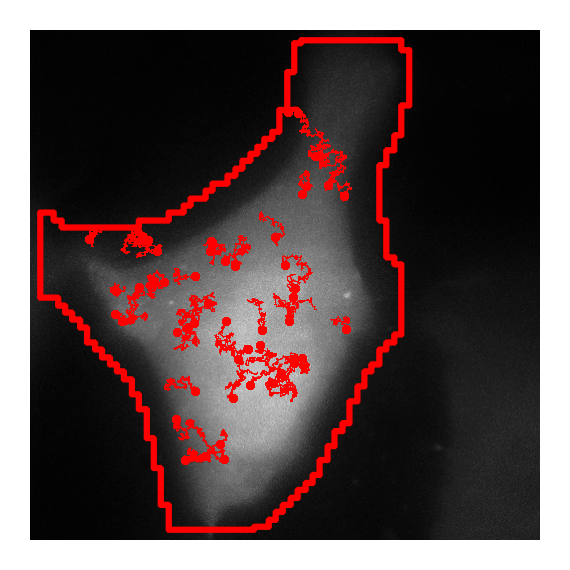

In [128]:
# Plotting individual trajectories history.
plt.figure(figsize=fig_size, dpi=300)
plt.imshow(list_videos[0][selected_timePoint, :, :, channel], cmap='Greys_r')
plt.axis('off')
# this loop iterated for each trajectory. This is achieved by using the total number of rows in x_loc, using this: ==> "x_loc.shape[0]"
for i in range(0, x_loc.shape[0]):
    # Then we plot the complete trajectory for each particle.
    plt.plot(x_loc[i, 0:300], y_loc[i, 0:300], '-', linewidth=0.1, color='r')
    # Then we plot the complete trajectory for each particle.
    plt.plot(x_loc[i, 0], y_loc[i, 0], marker='o', markersize=1, color='r')
contuour_position = find_contours(selected_mask[:, :], 0.8)
plt.fill(contuour_position[0][:, 1], contuour_position[0]
         [:, 0], facecolor='none', edgecolor='r', linewidth=1.5)  # mask nucleus
name_figure = name_files+'_CELL_trajectories.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.tight_layout()
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


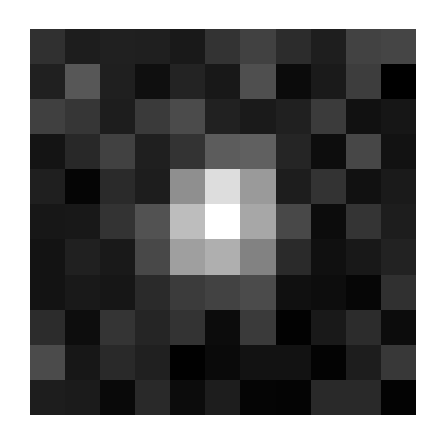

In [228]:

disk_size = 5
selected_spot = 0
y_pos = y_loc[selected_spot, time_vector[0]].astype(int)
x_pos = x_loc[selected_spot, time_vector[0]].astype(int)

plt.figure(figsize=fig_size, dpi=300)
crop_img = list_videos[0][time_vector[0], y_pos-(disk_size): y_pos+(
    disk_size+1), x_pos-(disk_size):x_pos+(disk_size+1),  channel]
plt.imshow(crop_img, cmap='Greys_r')
plt.tight_layout()
plt.axis('off')
name_figure = name_files+'_crop.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


In [222]:
plt.style.use('ggplot') #ggplot  #default
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True


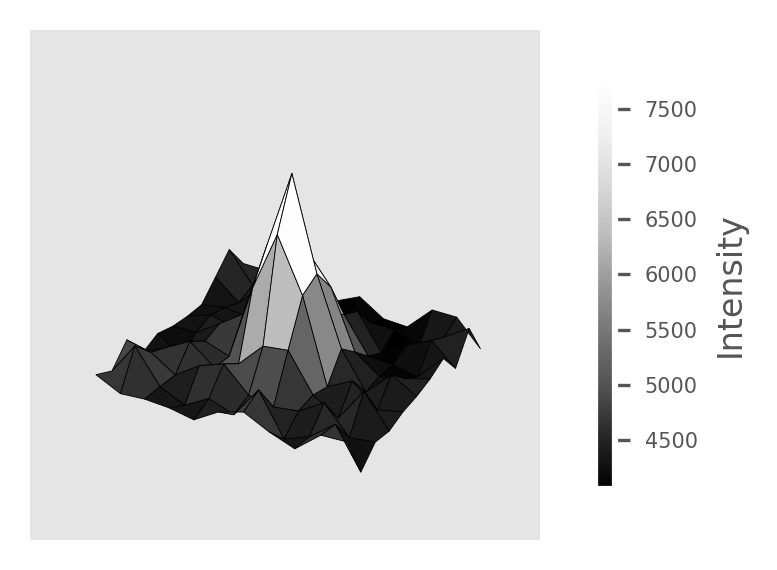

In [229]:

from mpl_toolkits import mplot3d
disk_size = 5
selected_spot = 0
y_pos = y_loc[selected_spot, time_vector[0]].astype(int)
x_pos = x_loc[selected_spot, time_vector[0]].astype(int)

crop_img = list_videos[0][time_vector[0], y_pos-(disk_size): y_pos+(
    disk_size+1), x_pos-(disk_size):x_pos+(disk_size+1),  channel]

# 3d Plotting

x = np.arange(0, crop_img.shape[0], 1)
y = np.arange(0, crop_img.shape[1], 1)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(4,2), dpi=300)
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, crop_img, rstride=1, cstride=1,
                cmap='Greys_r', edgecolor='k', linewidth=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Intenisty')

C = np.linspace(np.amin(crop_img), np.amax(crop_img), crop_img.size).reshape(crop_img.shape)
scamap = plt.cm.ScalarMappable(cmap='Greys_r')
fcolors = scamap.to_rgba(C)
cbar = fig.colorbar(scamap, shrink=0.8, aspect=20)
cbar.set_label(label='Intensity',size=8)
cbar.ax.tick_params(labelsize=5) 

#ax.view_init(60, 120)
plt.tight_layout()
plt.axis('off')
name_figure = name_files+'_crop_3D.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")
plt.show()


In [131]:
I_g.shape


(1000, 801)

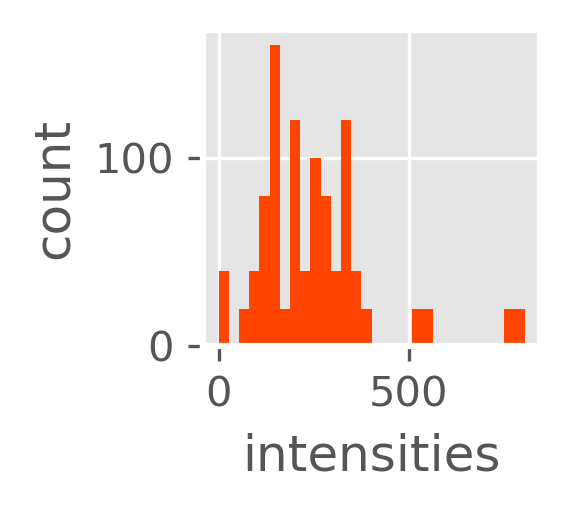

In [224]:
fig = plt.figure(figsize=(2, 1.8), dpi=300)
plt.hist(I_g[:, -1], bins=30, density=False, stacked=True, color='orangered')
# plt.title('Simulation')
plt.xlabel('intensities')
plt.ylabel('count')
plt.tight_layout()

name_figure = name_files+'_Hist.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")

plt.show()


In [225]:
def get_autocorrelation(data, g0='G0', norm='individual'):
    n_traj = data.shape[0]
    acf_vec = np.zeros(data.shape)

    def get_acc_fft(signal):
        N = len(signal)
        fvi = np.fft.fft(signal, n=2*N)
        acf = fvi*np.conjugate(fvi)
        acf = np.fft.ifft(acf)
        acf = np.real(acf[:N])/float(N)
        return acf

    global_mean = np.mean(data)
    global_var = np.var(data)
    for i in range(n_traj):
        if norm == 'individual':
            if np.mean(data[i] == 0):
                signal = (data[i] - 1e-6) / 1e-6
            else:
                signal = (data[i] - np.mean(data[i])) / np.var(data[i])
        else:
            signal = (data[i] - global_mean) / global_var
        if g0 == 'G1':
            g1 = get_acc_fft(signal)[1]
            acf_vec[i] = get_acc_fft(signal)/g1
        if g0 == 'G0':
            g = get_acc_fft(signal)[0]
            acf_vec[i] = get_acc_fft(signal)/g
    return acf_vec


In [134]:
# Calculating the auto-correlation function.
acf_from_data = get_autocorrelation(I_g, g0='G0', norm='none')
mean_acf = np.mean(acf_from_data, axis=0)
err_acf = np.std(acf_from_data, axis=0)  # /np.sqrt(I_g.shape[0])


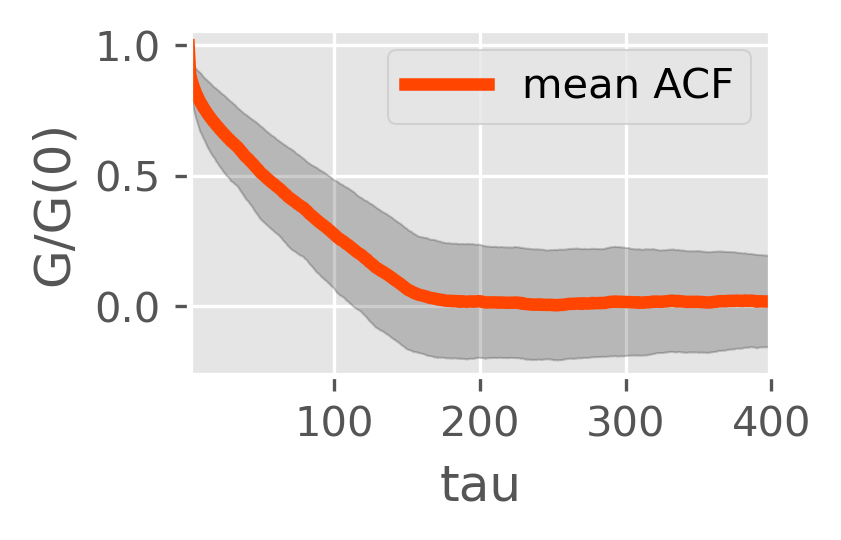

In [226]:
# Plotting the ACF and its mean.
plt.figure(figsize=(2.5, 1.5))
tau = np.arange(0, len(mean_acf), 1)
# plt.plot(acf_from_data.T,'green',alpha=.08)
plt.plot(tau, mean_acf, '-', linewidth=3, color='orangered', label='mean ACF')
plt.fill_between(tau, mean_acf - err_acf, mean_acf +
                 err_acf, color='k', alpha=0.2)
plt.xlim((1, 400))
plt.xlabel('tau')
plt.ylabel(r'G/G(0)')
plt.legend()
#plt.title('ACF for experimental data', color ='red')

name_figure = name_files+'_ACF.png'
figure_directory = str(dropbox_address.joinpath(name_figure))
plt.savefig(figure_directory, transparent=True, dpi=300, bbox_inches="tight")

plt.show()
